# Model Behavior
Apply logistic regression. Predict memory recall given alpha, gamma, and exponent changes on a single trial basis.

### Set path

In [1]:
PROJECT_PATH = 'C:/Users/micha/projects/oscillation_vs_exponent/'

## Set-up

### Imports

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_1samp
from scipy.stats import zscore
from scipy.io import loadmat

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score

from specparam import SpectralGroupModel, fit_models_3d
from specparam.utils import trim_spectrum


### Settings

In [ ]:
# dataset details
PATIENTS = ['pat02','pat04','pat05','pat08','pat10','pat11','pat15','pat16',
            'pat17','pat19','pat20','pat21','pat22'] # subject IDs

# analysis settings
ALPHA_BAND = [8, 20]
GAMMA_BAND = [50, 90]


In [ ]:
# example data
PATIENT = 'pat02'
CHAN_IDX = 0
MATERIAL = 'word'
MEMORY = 'hit'
EPOCH = 'prestim'

### Functions

In [ ]:
# Functions for single-trial spectral analysis
    
def run_analysis(spectra_pre, spectra_post, freq):
    """
    Run analysis on example data. Apply spectral parameterization and compute
    parameter differences between pre- and post-stimulus spectra.

    Parameters
    ----------
    spectra_pre, spectra_post : 2d array
        Spectra to compute parameter differences between.
    freq : 1d array
        Frequency values for spectra.

    Returns
    -------
    exp_diff, alpha_diff, gamma_diff : 2d array
        Parameter differences between pre- and post-stimulus spectra.
    """

    # apply SpecParam
    sgm = SpectralGroupModel(aperiodic_mode='knee', peak_width_limits=[2, 20], peak_threshold=3, verbose=False)
    sgm.set_check_modes(check_data=False)
    sgm_pre, sgm_post = sgm.copy(), sgm.copy()
    fit_models_3d(sgm_pre, freq, spectra_pre, n_jobs=-1)
    fit_models_3d(sgm_post, freq, spectra_post, n_jobs=-1)

    # compute parameter differences for each SpectralModel
    exp_diff = np.zeros(len(sgm_pre))
    alpha_diff = np.zeros(len(sgm_pre))
    gamma_diff = np.zeros(len(sgm_pre))
    for idx in range(len(sgm_pre)):
        results = compute_parameter_diff(sgm_pre.get_model(idx), sgm_post.get_model(idx))
        exp_diff[idx], alpha_diff[idx], gamma_diff[idx] = results
        
    # reshape results to match original data shape
    exp_diff = exp_diff.reshape(spectra_pre.shape[:2])
    alpha_diff = alpha_diff.reshape(spectra_pre.shape[:2])
    gamma_diff = gamma_diff.reshape(spectra_pre.shape[:2])

    return exp_diff, alpha_diff, gamma_diff
    

def compute_parameter_diff(sm_0, sm_1, alpha_band=[8, 20], gamma_band=[50, 90]):
    """
    Compute difference in spectral statistics between two spectral models, 
    including the aperiodic exponent, alpha band power, and gamma band power.

    Parameters
    ----------
    sm_0, sm_1 : SpectralModel
        Spectral models to compute parameter difference between.
    alpha_band, gamma_band : list of float
        Frequency ranges to compute band power over.

    Returns
    -------
    exp_diff, alpha_diff, gamma_diff : float
        Difference in spectral parameters between the two spectral models.
    
    """

    # compute difference in aperiodic exponent
    exp_diff = sm_1.aperiodic_params_[2] - sm_0.aperiodic_params_[2]

    # compute difference in alpha band power
    alpha_0 = compute_band_power(sm_0, alpha_band)
    alpha_1 = compute_band_power(sm_1, alpha_band)
    alpha_diff = alpha_1 - alpha_0

    # compute difference in gamma band power
    gamma_0 = compute_band_power(sm_0, gamma_band)
    gamma_1 = compute_band_power(sm_1, gamma_band)
    gamma_diff = gamma_1 - gamma_0

    return exp_diff, alpha_diff, gamma_diff


def compute_band_power(sm, f_range):
    """
    Compute band power for a given spectral model.

    Parameters
    ----------
    sm : SpectralModel
        Spectral model to compute band power for.
    f_range : list of float
        Frequency range to compute band power over.

    Returns
    -------
    power : float
        Band power for the given spectral model.
    
    """

    # compute flattened spectrum
    spectrum_flat = sm.power_spectrum - sm._ap_fit

    # compute band power
    _, band_power = trim_spectrum(sm.freqs, spectrum_flat, f_range)

    # take integral
    power = band_power.sum()

    return power


In [ ]:
# functions for behavioral modeling

def run_logistic_regression(results, patient, channel, material):
    """
    Run logistic regression to predict behavior from spectral parameters,
    for a given subject/channel/material.

    Parameters
    ----------
    results : pandas DataFrame
        Dataframe containing spectral parameters and behavior for each subject.
    patient, channel, material : str
        Data of interest: subject ID; channel index, material type ('word' or 'face').
        Used to subset the results dataframe.

    Returns
    -------
    clf : sklearn LogisticRegression object
        Logistic regression classifier.
    score : float
        Accuracy score for the classifier.
    """

    # get data
    index = (results['patient']==patient) & (results['channel']==channel) & (results['material']==material)
    X = results.loc[index, ['exp_diff', 'alpha_diff', 'gamma_diff']].to_numpy()
    y = results.loc[index, 'behavior'].to_numpy()

    # remove nans
    nan_idx = np.isnan(X).any(axis=1) | np.isnan(y)
    X = X[~nan_idx]
    y = y[~nan_idx]

    # z-score each feature
    X = zscore(X, axis=0)

    # run logistic regression
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    return clf, score



In [ ]:
# plotting functions

def plot_score(df):
    # plot scores by material
    fig, ax = plt.subplots(1,1, figsize=[6,4])
    bin_edges = np.arange(0,1.05,0.05)
    ax.hist(df.loc[df['material']=='word', 'score'], bin_edges, alpha=0.5, label='word-encoding')
    ax.hist(df.loc[df['material']=='face', 'score'], bin_edges, alpha=0.5, label='face-encoding')
    ax.axvline(0.5, color='k', linestyle='--')
    ax.set(xlabel='score', ylabel='count')
    ax.set_title("logistic regression scores")
    ax.legend()
    plt.show()

    # plot scores by patient and material
    fig, ax = plt.subplots(1,2, figsize=[12,4])
    bin_edges = np.arange(0,1.05,0.05)
    for i_patient, patient in enumerate(PATIENTS):
        # plot histogram of scores for each patient
        ax[0].hist(df.loc[(df['patient']==patient) & (df['material']=='word'), 'score'], bin_edges, alpha=0.5, color=f'C{i_patient}')
        ax[1].hist(df.loc[(df['patient']==patient) & (df['material']=='face'), 'score'], bin_edges, alpha=0.5, color=f'C{i_patient}')
        # plot mean score for each patient
        ax[0].axvline(df.loc[(df['patient']==patient) & (df['material']=='word'), 'score'].mean(), color=f'C{i_patient}', linestyle='--')
        ax[1].axvline(df.loc[(df['patient']==patient) & (df['material']=='face'), 'score'].mean(), color=f'C{i_patient}', linestyle='--')
    ax[0].set(xlabel='patient', ylabel='score', title='word-encoding')
    ax[1].set(xlabel='patient', ylabel='score', title='face-encoding')
    plt.show()

    # print mean scores
    print(f"mean score:\t\t {df['score'].mean():0.3f}")
    print(f"\nmean word score:\t {df.loc[df['material']=='word', 'score'].mean():0.3f}")
    print(f"median word score:\t {df.loc[df['material']=='word', 'score'].median():0.3f}")
    print(f"\nmean face score:\t {df.loc[df['material']=='face', 'score'].mean():0.3f}")
    print(f"median face score:\t {df.loc[df['material']=='face', 'score'].median():0.3f}")


## Main

### Run single-trial spectral analysis

In [8]:
# Apply single-trial spectral analysis to all data

# results = pd.DataFrame(columns=['patient', 'material', 'trial', 'channel', 'behavior', 'exp_diff', 'alpha_diff', 'gamma_diff'])
# for patient in PATIENTS:
#     for material in ['word', 'face']:
#         # display progress
#         print(f"Processing {patient} {material}")

#         # load data
#         fname = fr"C:\Users\micha\projects\oscillation_vs_exponent\data\ieeg_psd\{patient}_{material}s_YYY_XXXstim_psd.npz"
#         data_pre_hit = np.load(fname.replace("XXX", 'pre').replace("YYY", 'hit'), allow_pickle=True)
#         data_pre_miss = np.load(fname.replace("XXX", 'pre').replace("YYY", 'miss'), allow_pickle=True)
#         spectra_pre = np.concatenate([data_pre_hit['psd'], data_pre_miss['psd']], axis=0)
#         freq = data_pre_hit['freq']
#         data_post_hit = np.load(fname.replace("XXX", 'post').replace("YYY", 'hit'), allow_pickle=True)
#         data_post_miss = np.load(fname.replace("XXX", 'post').replace("YYY", 'miss'), allow_pickle=True)
#         spectra_post = np.concatenate([data_post_hit['psd'], data_post_miss['psd']], axis=0)

#         # run analysis
#         exp_diff, alpha_diff, gamma_diff = run_analysis(spectra_pre, spectra_post, freq)

#         # define behavior
#         behavior = np.zeros(len(data_pre_hit['psd']) + len(data_pre_miss['psd']))
#         behavior[:len(data_pre_hit['psd'])] = 1

#         # add to dataframe
#         for i_trial in range(exp_diff.shape[0]):
#             for i_chan in range(exp_diff.shape[1]):
#                 results_ii = pd.DataFrame({'patient' : patient,
#                                             'material' : material,
#                                             'trial' : i_trial,
#                                             'channel' : i_chan,
#                                             'behavior' : behavior[i_trial],
#                                             'exp_diff' : exp_diff[i_trial, i_chan],
#                                             'alpha_diff' : alpha_diff[i_trial, i_chan],
#                                             'gamma_diff' : gamma_diff[i_trial, i_chan]},
#                                             index=[0])
#                 results = pd.concat([results, results_ii], axis=0)

# # save / show
# results.to_csv(fr"{PROJECT_PATH}\data\results\df_logistic_regression.csv")

In [9]:
# load results from above
results = pd.read_csv(fr"{PROJECT_PATH}\data\results\df_logistic_regression.csv", index_col=0)
results

,patient,material,trial,channel,behavior,exp_diff,alpha_diff,gamma_diff
0,pat02,word,0,0,1.0,-0.279484,-3.110285,2.629643
0,pat02,word,0,1,1.0,0.269273,2.262207,4.900481
0,pat02,word,0,2,1.0,-0.340540,-3.034364,-1.100768
0,pat02,word,0,3,1.0,-0.710333,0.133164,-12.508012
0,pat02,word,0,4,1.0,0.794202,-3.127827,7.946793
...,...,...,...,...,...,...,...,...
0,pat22,face,99,48,0.0,NaN,NaN,NaN
0,pat22,face,99,49,0.0,NaN,NaN,NaN
0,pat22,face,99,50,0.0,NaN,NaN,NaN
0,pat22,face,99,51,0.0,NaN,NaN,NaN


### Run logistic regression

In [10]:
# run logistic regression for all channels in each trial condition

# create dataframe to store results (one row for each channel-material pair)
df = results.groupby(['patient', 'channel', 'material']).mean().reset_index()
df = df[['patient', 'channel', 'material']]
df[['exp_coef', 'alpha_coef', 'gamma_coef', 'score']] = np.nan 

# run logistic regression 
score = np.zeros([len(PATIENTS), 2])
coef = np.zeros([len(PATIENTS), 2, 3])
for i_patient, patient in enumerate(PATIENTS):
    channels = results.loc[results['patient']==patient, 'channel'].unique()
    for channel in channels:
        for i_material, material in enumerate(['word', 'face']):
            try: # some patients/channels don't have data ! CHECK SPECIFIC INSTANCES ! 
                clf, score = run_logistic_regression(results, patient, channel, material)
                df_index = (df['patient']==patient) & (df['channel']==channel) & (df['material']==material)
                df.loc[df_index, ['exp_coef', 'alpha_coef', 'gamma_coef']] = clf.coef_
                df.loc[df_index, 'score'] = score
            except:
                pass

df

,patient,channel,material,exp_coef,alpha_coef,gamma_coef,score
0,pat02,0,face,-0.123269,0.282779,0.444341,0.750000
1,pat02,0,word,-0.066053,-0.016757,-0.239730,0.875000
2,pat02,1,face,0.310084,-0.042471,0.177358,0.705882
3,pat02,1,word,-0.232792,0.163456,0.013133,0.764706
4,pat02,2,face,-0.039996,0.275513,-0.275364,0.631579
...,...,...,...,...,...,...,...
1338,pat22,50,word,-0.112174,-0.108510,-0.338119,0.450000
1339,pat22,51,face,-0.204465,0.223212,-0.180400,0.611111
1340,pat22,51,word,-0.523250,0.165733,-0.115293,0.650000
1341,pat22,52,face,-0.153161,0.124564,-0.178065,0.611111


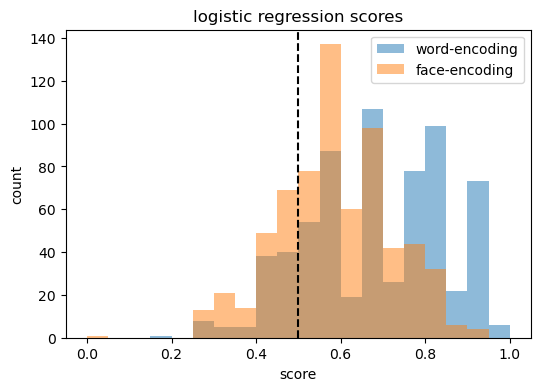

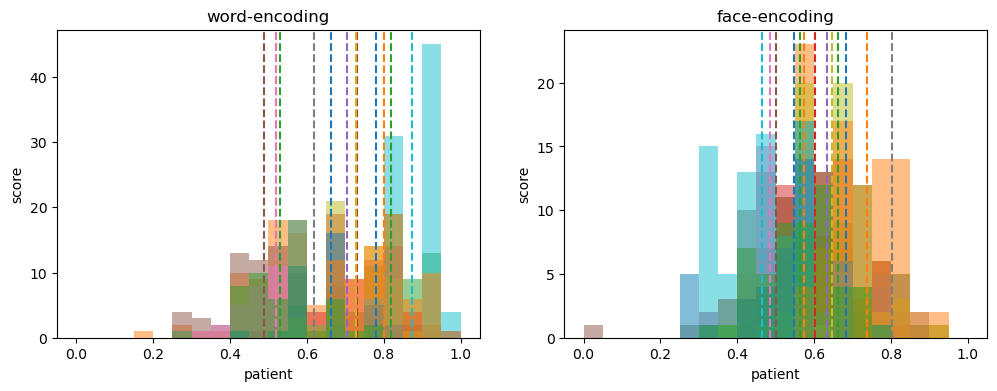

mean score:		 0.632

mean word score:	 0.680
median word score:	 0.700

mean face score:	 0.585
median face score:	 0.600


In [11]:
# plot results and print average scores

plot_score(df)

The median prediction score is higher for the word-encoding block (70%) than face-encoding block (60%). Additionally, there is much greater between subject variability in scores for word-encoding block.

### Analyze results

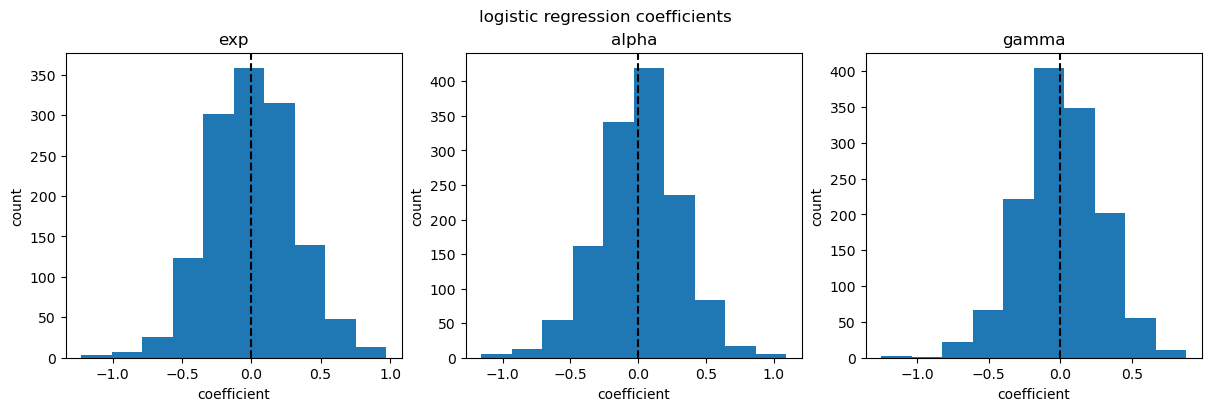

Mean coefficients:
exp:	 0.00621
alpha:	 0.00952
gamma:	 0.00571


T-test results:
exp:	 t=0.734, p=0.463
alpha:	 t=1.157, p=0.247
gamma:	 t=0.752, p=0.452


T-test, word-encoding:
exp:	 t=2.086, p=0.037
alpha:	 t=0.308, p=0.758
gamma:	 t=-0.234, p=0.815


T-test, face-encoding:
exp:	 t=-1.088, p=0.277
alpha:	 t=1.332, p=0.183
gamma:	 t=1.358, p=0.175


In [12]:
# plot coefficients
fig, axes = plt.subplots(1,3, figsize=[12,4], constrained_layout=True)
fig.suptitle("logistic regression coefficients")
for i_ax, ax in enumerate(axes):
    ax.hist(df.iloc[:,i_ax+3])
    ax.set_title(df.columns[i_ax+3].split('_')[0])
    ax.set(xlabel='coefficient', ylabel='count')
    ax.axvline(0, color='k', linestyle='--')
plt.show()

# print coefficients
print(f"Mean coefficients:")
print(f"exp:\t {df['exp_coef'].mean():0.5f}")
print(f"alpha:\t {df['alpha_coef'].mean():0.5f}")
print(f"gamma:\t {df['gamma_coef'].mean():0.5f}")

# run 1 sample t-test
print("\n\nT-test results:")
for ii in range(3):
    data_i = df.iloc[:,ii+3]
    data_i = data_i[~np.isnan(data_i)]
    t, p = ttest_1samp(data_i, 0)
    print(f"{df.columns[ii+3].split('_')[0]}:\t t={t:0.3f}, p={p:0.3f}")
    
# run 1 sample t-test for word-/face-encoding only
for material in ['word', 'face']:
    print(f"\n\nT-test, {material}-encoding:")
    df_m = df.loc[df['material']==material] # subset dataframe
    for ii in range(3):
        data_i = df_m.iloc[:,ii+3]
        data_i = data_i[~np.isnan(data_i)]
        t, p = ttest_1samp(data_i, 0)
        print(f"{df.columns[ii+3].split('_')[0]}:\t t={t:0.3f}, p={p:0.3f}")



T-test, all trials:
exp:	 t=3.51616, p=0.00050
alpha:	 t=0.56266, p=0.57406
gamma:	 t=-0.22292, p=0.82374


T-test, word-encoding:
exp:	 t=3.74665, p=0.00022
alpha:	 t=0.85834, p=0.39152
gamma:	 t=-1.15633, p=0.24863


T-test, face-encoding:
exp:	 t=0.41435, p=0.67998
alpha:	 t=-0.47377, p=0.63725
gamma:	 t=2.24309, p=0.02831


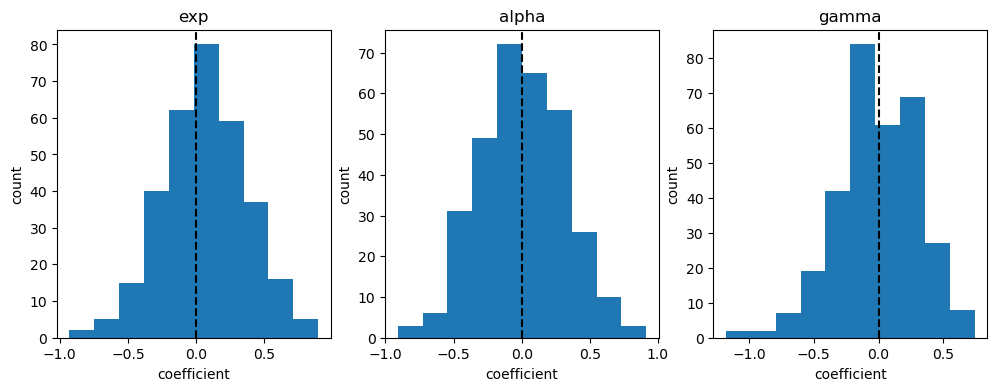

In [12]:
# plot coefficients for high scores only (score>75%) and run 1 sample t-test

# got coef for high scores
df_high = df.loc[df['score']>0.75]
fig, axes = plt.subplots(1,3, figsize=[12,4])
for i_ax, ax in enumerate(axes):
    ax.hist(df_high.iloc[:,i_ax+3])
    ax.axvline(0, color='k', linestyle='--')
    ax.set_title(df.columns[i_ax+3].split('_')[0])
    ax.set(xlabel='coefficient', ylabel='count')
    
# run 1 sample t-test
print("\n\nT-test, all trials:")
for i_ax, ax in enumerate(axes):
    data_i = df_high.iloc[:,i_ax+3]
    data_i = data_i[~np.isnan(data_i)]
    t, p = ttest_1samp(data_i, 0)
    print(f"{df.columns[i_ax+3].split('_')[0]}:\t t={t:0.5f}, p={p:0.5f}")

for material in ['word', 'face']:
    print(f"\n\nT-test, {material}-encoding:")
    for ii in range(3):
        df_m = df_high.loc[df_high['material']==material]
        data_i = df_m.iloc[:,ii+3]
        data_i = data_i[~np.isnan(data_i)]
        t, p = ttest_1samp(data_i, 0)
        print(f"{df.columns[ii+3].split('_')[0]}:\t t={t:0.5f}, p={p:0.5f}")

These results suggest that modulation of the aperiodic exponent on a single-trial basis is predictive of memory recall for word-encoding trials but not for face-eencoding trials. 

## Analyze topography of regression score
* repeat regression, computing mean score with cross validation
* plot scores on brain mesh

### run regression
compute mean score with cross validation

In [13]:
# load results from above
results = pd.read_csv(fr"{PROJECT_PATH}\data\results\df_logistic_regression.csv", index_col=0)
results

,patient,material,trial,channel,behavior,exp_diff,alpha_diff,gamma_diff
0,pat02,word,0,0,1.0,-0.279484,-3.110285,2.629643
0,pat02,word,0,1,1.0,0.269273,2.262207,4.900481
0,pat02,word,0,2,1.0,-0.340540,-3.034364,-1.100768
0,pat02,word,0,3,1.0,-0.710333,0.133164,-12.508012
0,pat02,word,0,4,1.0,0.794202,-3.127827,7.946793
...,...,...,...,...,...,...,...,...
0,pat22,face,99,48,0.0,NaN,NaN,NaN
0,pat22,face,99,49,0.0,NaN,NaN,NaN
0,pat22,face,99,50,0.0,NaN,NaN,NaN
0,pat22,face,99,51,0.0,NaN,NaN,NaN


In [14]:
# functions for behavioral modeling

def run_logistic_regression_cv(results, patient, channel, material):
    """
    Run logistic regression to predict behavior from spectral parameters,
    for a given subject/channel/material.

    Parameters
    ----------
    results : pandas DataFrame
        Dataframe containing spectral parameters and behavior for each subject.
    patient, channel, material : str
        Data of interest: subject ID; channel index, material type ('word' or 'face').
        Used to subset the results dataframe.

    Returns
    -------
    clf : sklearn LogisticRegression object
        Logistic regression classifier.
    score : float
        Accuracy score for the classifier.
    """

    # get data
    index = (results['patient']==patient) & (results['channel']==channel) & (results['material']==material)
    X = results.loc[index, ['exp_diff', 'alpha_diff', 'gamma_diff']].to_numpy()
    y = results.loc[index, 'behavior'].to_numpy()

    # remove nans
    nan_idx = np.isnan(X).any(axis=1) | np.isnan(y)
    X = X[~nan_idx]
    y = y[~nan_idx]

    # z-score each feature
    X = zscore(X, axis=0)

    # run logistic regression with cross-validation
    clf = LogisticRegression(random_state=0)
    scores = cross_val_score(clf, X, y, cv=5)
    score = scores.mean()

    return clf, score



In [15]:
# run logistic regression for all channels in each trial condition

# create dataframe to store results (one row for each channel-material pair)
df = results.groupby(['patient', 'channel', 'material']).mean().reset_index()
df = df[['patient', 'channel', 'material']]
# df[['exp_coef', 'alpha_coef', 'gamma_coef', 'score']] = np.nan 
df['score'] = np.nan 

# run logistic regression 
score = np.zeros([len(PATIENTS), 2])
coef = np.zeros([len(PATIENTS), 2, 3])
for i_patient, patient in enumerate(PATIENTS):
    channels = results.loc[results['patient']==patient, 'channel'].unique()
    for channel in channels:
        for i_material, material in enumerate(['word', 'face']):
            try: # some patients/channels don't have data ! CHECK SPECIFIC INSTANCES ! 
                clf, score = run_logistic_regression_cv(results, patient, channel, material)
                df_index = (df['patient']==patient) & (df['channel']==channel) & (df['material']==material)
                # df.loc[df_index, ['exp_coef', 'alpha_coef', 'gamma_coef']] = clf.coef_
                df.loc[df_index, 'score'] = score
            except:
                pass

df

c:\Users\micha\anaconda3\envs\oscillation_vs_exponent\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\micha\anaconda3\envs\oscillation_vs_exponent\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\micha\anaconda3\envs\oscillation_vs_exponent\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "

,patient,channel,material,score
0,pat02,0,face,0.611667
1,pat02,0,word,0.787500
2,pat02,1,face,0.588971
3,pat02,1,word,0.793382
4,pat02,2,face,0.628070
...,...,...,...,...
1338,pat22,50,word,0.544737
1339,pat22,51,face,0.570588
1340,pat22,51,word,0.602105
1341,pat22,52,face,0.593464


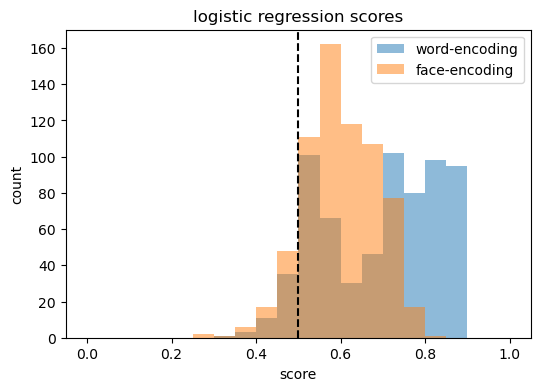

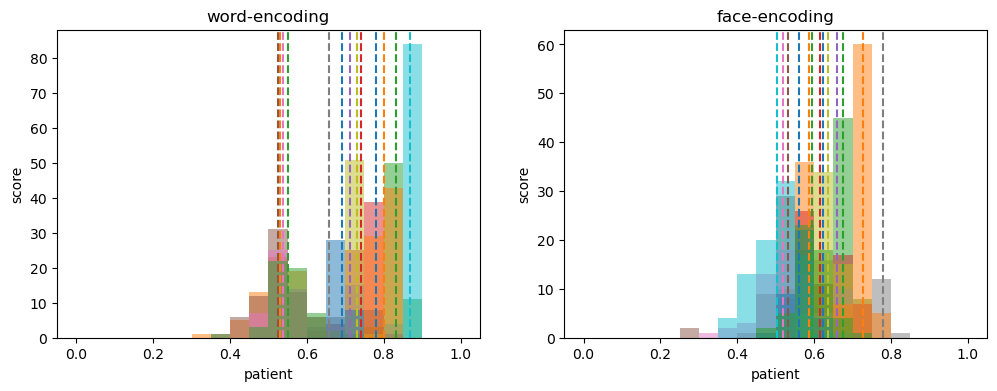

mean score:		 0.646

mean word score:	 0.692
median word score:	 0.722

mean face score:	 0.601
median face score:	 0.597


In [16]:
# plot histogram of regression scores
plot_score(df)

In [25]:
# save results
df.to_csv(fr"{PROJECT_PATH}\data\results\df_logistic_regression_cv.csv")

### plot topography of regression results

switch to pyvista environment

#### set-up

In [1]:
# set path
PROJECT_PATH = 'C:/Users/micha/projects/oscillation_vs_exponent/'

In [5]:
# imports

# general
import os
import pandas as pd
import numpy as np

# local
import sys
sys.path.append(f"{PROJECT_PATH}/code")
from pyvista_utils import load_brain_meshes, default_camera_pos
from plots import plot_data_spatial

In [6]:
# auto reload
%load_ext autoreload
%autoreload 2

#### load data

In [7]:
# load regression results from above
results = pd.read_csv(fr"{PROJECT_PATH}\data\results\df_logistic_regression_cv.csv", index_col=0)
results

,patient,channel,material,score
0,pat02,0,face,0.611667
1,pat02,0,word,0.787500
2,pat02,1,face,0.588971
3,pat02,1,word,0.793382
4,pat02,2,face,0.628070
...,...,...,...,...
1338,pat22,50,word,0.544737
1339,pat22,51,face,0.570588
1340,pat22,51,word,0.602105
1341,pat22,52,face,0.593464


In [8]:
# load electrode locations
df_elec = pd.read_csv(f"{PROJECT_PATH}/data/ieeg_metadata/ieeg_channel_info.csv", index_col=0)
df_elec.drop(columns=['index'], inplace=True)
df_elec.rename(columns={'chan_idx':'channel'}, inplace=True)
df_elec

,patient,channel,label,pos_y,pos_x,pos_z
0,pat02,0,A01-A02,-65.43100,61.94490,3.55955
1,pat02,1,A02-A03,-70.93895,57.17765,12.15540
2,pat02,2,A03-A04,-75.39550,51.39440,20.94335
3,pat02,3,A04-A05,-78.91950,43.90980,30.13485
4,pat02,4,A05-A06,-80.96735,35.21485,38.13475
...,...,...,...,...,...,...
690,pat22,48,MOF_03-MOF_04,36.00000,-14.00000,3.00000
691,pat22,49,MOF_04-MOF_07,40.50000,-14.00000,9.50000
692,pat22,50,MOF_07-MOF_08,44.50000,-14.00000,16.50000
693,pat22,51,MOF_08-MOF_09,48.00000,-14.00000,23.50000


In [9]:
# merge channel info with regression results
df = pd.merge(results, df_elec, on=['patient', 'channel'])
df

,patient,channel,material,score,label,pos_y,pos_x,pos_z
0,pat02,0,face,0.611667,A01-A02,-65.43100,61.94490,3.55955
1,pat02,0,word,0.787500,A01-A02,-65.43100,61.94490,3.55955
2,pat02,1,face,0.588971,A02-A03,-70.93895,57.17765,12.15540
3,pat02,1,word,0.793382,A02-A03,-70.93895,57.17765,12.15540
4,pat02,2,face,0.628070,A03-A04,-75.39550,51.39440,20.94335
...,...,...,...,...,...,...,...,...
1338,pat22,50,word,0.544737,MOF_07-MOF_08,44.50000,-14.00000,16.50000
1339,pat22,51,face,0.570588,MOF_08-MOF_09,48.00000,-14.00000,23.50000
1340,pat22,51,word,0.602105,MOF_08-MOF_09,48.00000,-14.00000,23.50000
1341,pat22,52,face,0.593464,MOF_09-MOF_10,52.00000,-14.00000,30.00000


In [10]:
# load brain mesh data
brain_mesh = load_brain_meshes()
brain_mesh

{'right': PolyData (0x199d8bab8e0)
   N Cells:    342176
   N Points:   171090
   N Strips:   0
   X Bounds:   -1.110e+00, 7.094e+01
   Y Bounds:   -1.094e+02, 7.427e+01
   Z Bounds:   -5.342e+01, 8.390e+01
   N Arrays:   0,
 'left': PolyData (0x199d8baaf80)
   N Cells:    350814
   N Points:   175409
   N Strips:   0
   X Bounds:   -7.051e+01, 4.837e+00
   Y Bounds:   -1.112e+02, 7.301e+01
   Z Bounds:   -4.982e+01, 8.209e+01
   N Arrays:   0,
 'both': PolyData (0x199d8baa440)
   N Cells:    692990
   N Points:   346499
   N Strips:   0
   X Bounds:   -7.051e+01, 7.094e+01
   Y Bounds:   -1.112e+02, 7.427e+01
   Z Bounds:   -5.342e+01, 8.390e+01
   N Arrays:   0}

In [11]:
# load default camera position
cpos = default_camera_pos()
cpos

{'right': [(522.8751422878058, -8.533968557192056, 2.1119098264702054),
  (0.21547583547528149, -18.471318770726832, 15.236837161591453),
  (0.023688404036230154, 0.07114592740239216, 0.9971845950115104)],
 'left': [(-520.3531805339194, -38.83703309211285, 60.37721009778639),
  (0.21547583547528149, -18.471318770726832, 15.236837161591453),
  (0.08481614834082721, 0.038835387452391915, 0.9956395098940428)],
 'posterior': [(15.14386468264713, -479.3300209752663, 261.87532035441575),
  (0.21547583547528149, -18.471318770726832, 15.236837161591453),
  (-0.0024849751700573297, 0.47178555248856824, 0.8817098260547291)]}

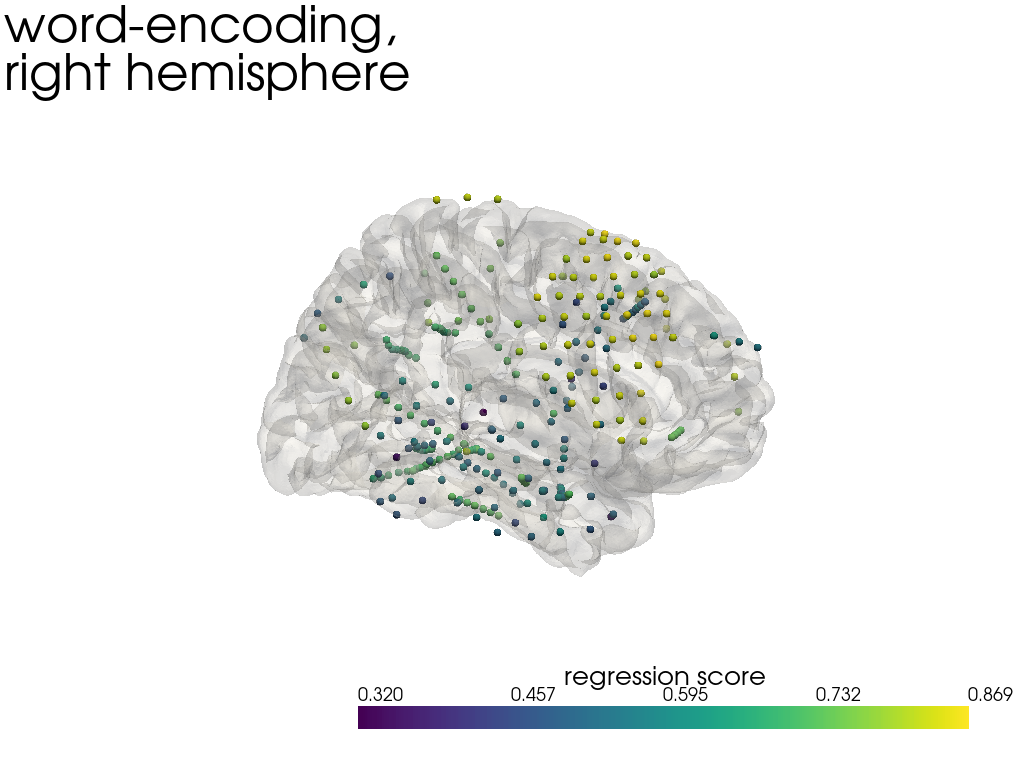

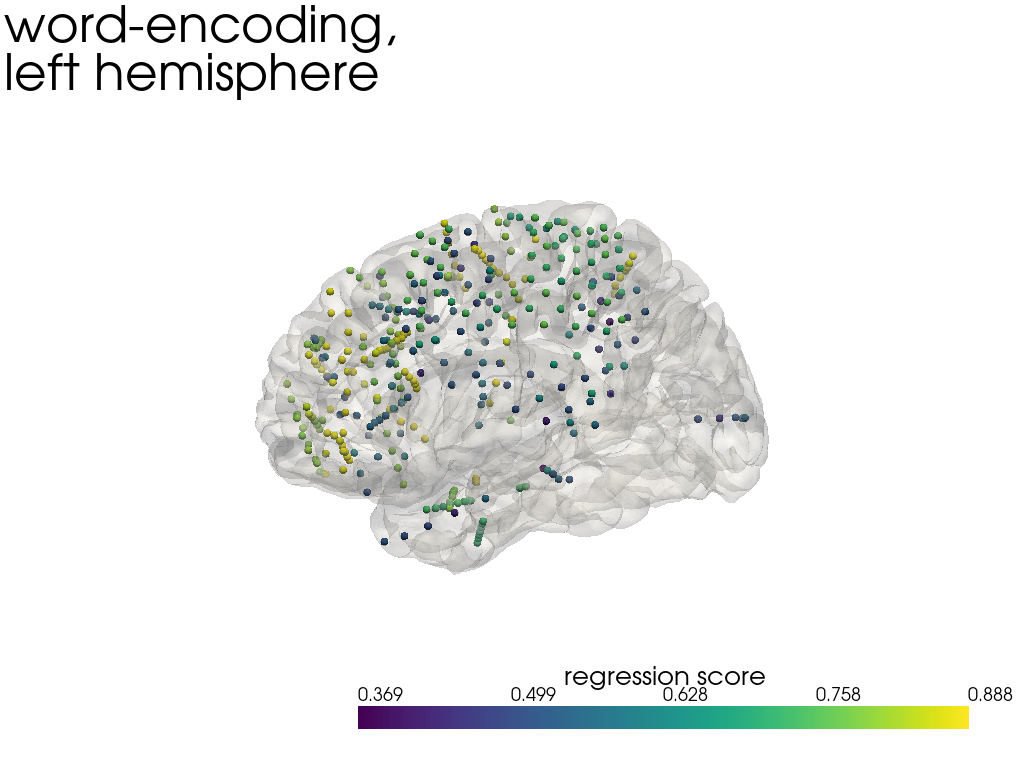

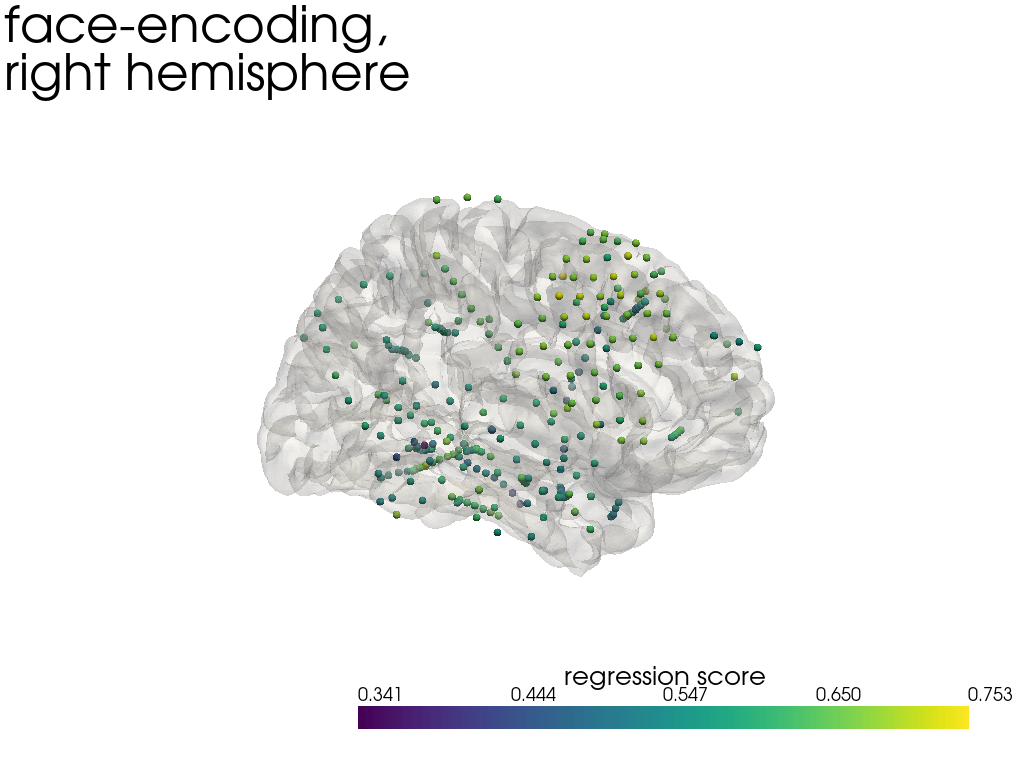

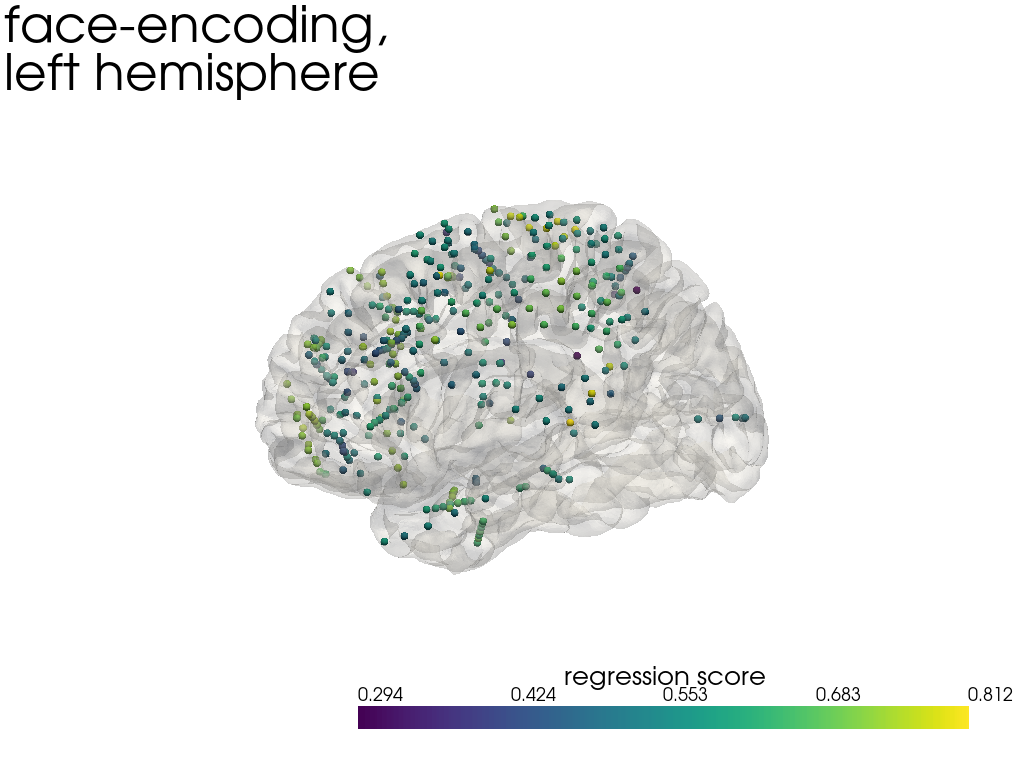

In [21]:
# plot topo map of scores

# loop through materials
for material in ['word', 'face']:

    # get info for trial block 
    df_i = df.loc[df['material']==material]
    df_i = df_i.dropna()
    elec_pos = df_i[['pos_x', 'pos_y', 'pos_z']]

    # split data by hemisphere
    pos = dict()
    score = dict()
    pos['right'] = elec_pos[elec_pos['pos_x'] >= 0].to_numpy()
    score['right'] = df_i.loc[df_i['pos_x'] >= 0, 'score'].to_numpy()
    pos['left'] = elec_pos[elec_pos['pos_x'] < 0].to_numpy()
    score['left'] = df_i.loc[df_i['pos_x'] < 0, 'score'].to_numpy()

    # plot ech hemisphere 
    for hemi in ['right', 'left']:
        plot_data_spatial(brain_mesh[hemi], pos[hemi], score[hemi], cpos=cpos[hemi],
                    backgrouond_color='w', brain_opacity=0.2, value_label='regression score',
                    title=f"{material}-encoding,\n{hemi} hemisphere")